    imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import xgboost as xgb
from sklearn.model_selection import train_test_split
import sklearn
import random
import catboost
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
%matplotlib inline

    Downloading Data
    
    Creating df which includes text data. No NaNs

In [3]:
'''
    Downloading Data
    
    Creating df which includes text data
'''

df = pd.read_csv("regulations.csv")
df_texts = pd.read_csv("regulations_texts.csv", sep=";")
answers = pd.read_csv("train_answer.csv")
df_reports = pd.read_csv('ria_reports/ria_reports/ria_reports_main.csv', sep=";")

df['publication_date'] = pd.to_datetime(df['publication_date'])
df['text'] = [df_texts[df_texts['regulation_project_id'] == x].iat[0,1] 
              if x in set(df_texts['regulation_project_id']) else 'nothing' for x in df['id']]
df['co_developer'] = [df_reports[df_reports['regulation_project_id'] == x].iat[0,3] 
              if x in set(df_reports['regulation_project_id']) else 'nothing' for x in df['id']]

#Get rid of nans
for col in df:
    #get dtype for column
    dt = df[col].dtype 
    #check if it is a number
    if dt == int or dt == float or dt == 'float64':
        df[col] = df[col].fillna(0)
    else:
        df[col] = df[col].fillna("nothing")

len(df_texts)

11384


    Preparing Data
    
    Creating df1 which has only numeric data


In [81]:
'''
    Preparing Data
    
    Creating df1 which has only numeric data
'''
def dev_columns(X, y, style=0):
    '''
        Dealing with "developers"
    '''
    X = X.copy()
    if style==-1:
        return X
    if style==0:
        return pd.get_dummies(X,columns=["developer"])
    else:
        X['answer'] = y
        dev_mean = X.groupby('developer').agg({'answer': 'mean'}).sort_values('answer', ascending=False)
        D = dict(zip(dev_mean.index, dev_mean['answer']))
        X['dev_mean'] = [D[x] for x in X['developer']]
        if style==1:
            del X['answer']
            del X['developer']
            return X
        else:
            dev_count = X.groupby('developer').agg({'answer': 'count'}).sort_values('answer', ascending=False)
            D = dict(zip(dev_count.index, dev_count['answer']))
            X['dev_count'] = [D[x] for x in X['developer']]
            if style==2:
                del X['answer']
                del X['developer']
                return X
            else:
                X['dev_succes'] = X['dev_mean']*X['dev_count']
                if style==3:
                    del X['answer']
                    del X['developer']
                    return X
                else:
                    X = pd.get_dummies(X,columns=["developer"])
                    if style==4:
                        del X['answer']
                        return X
                    else:
                        if style==5:
                            for col in dev_mean.index[30:]:
                                del X[f'developer_{col}']
                            #print(X.columns)
                            #X.drop(dev_mean.index[30:], axis=1, inplace=True)
                            del X['answer']
                            return X
                        
def co_dev_columns(X, y, style=0):
    '''
        Dealing with "co_developers"
    '''
    
    X = X.copy()
    X['answer'] = y
    X['co_developer_bool'] = [0 if x.lstrip().lower() in ['nothing', 'нет', 'отсутствуют', '-', 'соисполнителейнет', 
                                                         'соисполнителей-нет','соисполнителиотсутствуют'] else 
                            1 for x in df['co_developer']]
#     X['co_developer_count'] = [0 if x.lstrip().lower() in ['nothing', 'нет', 'отсутствуют', '-', 'соисполнителейнет', 
#                                                              'соисполнителей-нет','соисполнителиотсутствуют'] else 
#                              len(x.split(',')) for x in df['co_developer']]
    X['co_dev_mean'] = [0 for i in range(len(X))]
    X['co_developer_count'] = [0 for i in range(len(X))]
    for x in df['developer'].unique():
        if x != 'nothing':
            X['co_dev_' + x] = [1 if x in t else 0 for t in df['co_developer']]
            X['co_developer_count'] = X['co_developer_count'] + X['co_dev_' + x]
            if X['co_dev_' + x].sum() != 0:
                #print(f"Num of co_dev_{x} approved: {(X['co_dev_' + x]*X['answer']).sum()}\nNum of co_dev_{x}: {X['co_dev_' + x].sum()}")
                succ_rate = (X['co_dev_' + x]*X['answer']).sum()/X['co_dev_' + x].sum()
                X['co_dev_' + x] = [succ_rate if t != 0 else 0 for t in X['co_dev_' + x]]
                X['co_dev_mean'] = X['co_dev_mean'] + X['co_dev_' + x]

            if style==0:
                del X['co_dev_' + x]

    X['co_dev_mean'] = X['co_dev_mean']/X['co_developer_count']
    X['co_dev_mean'] = [x if x < 10000 else 0 for x in X['co_dev_mean']]
    del X['co_developer_count']
    del X['answer']
    return X

def person_mean(X, y):
    '''
        Dealing with "added_by" and "responsible"
    '''
    #X = X[X['id'].isin(answers['id'])].copy()
    X = X.copy()
    X['answer'] = y
    X['added_by'] = df['added_by']
    X['responsible'] = df['responsible']
    added_by = X.groupby('added_by').agg({'answer': 'mean'}).sort_values('answer', ascending=False)
    responsible = X.groupby('responsible').agg({'answer': 'mean'}).sort_values('answer', ascending=False)
    D = dict(zip(added_by.index, added_by['answer']))
    X['added_by_mean'] = [D[x] for x in X['added_by']]
    D = dict(zip(responsible.index, responsible['answer']))
    X['responsible_mean'] = [D[x] for x in X['responsible']]
    del X['answer']
    del X['added_by']
    del X['responsible']
    return X





def data_proc(df, answers):
    df1 = df.loc[:,['id', 'publication_date', 'act_title', 'developer', 'okved_list', 'views_num', 
                    'dislikes_num', 'regulatory_impact', 
                    'is_regionally_signigicant', 'act_changes_controlling_activities', 'mineco_solution',
                    'problem_addressed', 'act_objectives', 'persons_affected_by_act',
                    'relations_regulated_by_act','act_significance']]

    id_dict = dict(zip(answers['id'],answers['passed']))
    y = np.array([id_dict.get(i, np.nan) for i in df1['id']])
    
    #df1 = dev_columns(df1,y, style=4)
    df1['text'] = [0 if x == 'nothing' else 1 for x in df['text']]
    df1['text_len'] = [0 if x == 'nothing' else len(x) for x in df['text']]
    df1.loc[:,['is_regionally_signigicant']] = [1 if i == True else 0 for i in df1['is_regionally_signigicant']]
    df1.loc[:,['act_changes_controlling_activities']] = [1 if i == True else 0 
                                                         for i in df1['act_changes_controlling_activities']]


    df1.loc[:,['problem_addressed', 'act_objectives', 'persons_affected_by_act', 'relations_regulated_by_act',
               'act_significance']] = df1.loc[:,['problem_addressed', 'act_objectives', 'persons_affected_by_act',
                    'relations_regulated_by_act','act_significance']].applymap(lambda x: 0 if x=='nothing' else 1)
    df1['okved_list'] = [0 if x=='nothing' else 1 for x in df1['okved_list']]
    df1['year'] = [0 if x=='nothing' else x.year for x in df['publication_date']]
    df1['month'] = [0 if x=='nothing' else x.month for x in df['publication_date']]
    df1['year_end'] = [ min(2021*12 + 9 - df1['year'][i]*12 - df1['month'][i], 12) for i in df1.index]

    #Dealing with persons (added_by and responsible)
    df1['same_person'] = (df['added_by'] == df['responsible'])
    responsible = pd.DataFrame(np.unique(df['responsible'], return_counts=True)).transpose()
    responsible = dict(zip(responsible[0], responsible[1]))
    responsible['nothing'] = 0
    added_by = pd.DataFrame(np.unique(df['added_by'], return_counts=True)).transpose()
    added_by = dict(zip(added_by[0], added_by[1]))
    added_by['nothing'] = 0
    #added_by
    df1['responsible_count'] = [responsible[x] for x in df['responsible']]
    df1['added_by_count'] = [added_by[x] for x in df['added_by']]

    
    #df1 = person_mean(df1, y)
    
    
    
#     df1['co_developer_count'] = [0 if x.lstrip().lower() in ['nothing', 'нет', 'отсутствуют', '-', 'соисполнителейнет', 
#                                                          'соисполнителей-нет','соисполнителиотсутствуют'] else 
#                             len(x.split(',')) for x in df['co_developer']]
    df1['co_developer_bool'] = [0 if x.lstrip().lower() in ['nothing', 'нет', 'отсутствуют', '-', 'соисполнителейнет', 
                                                         'соисполнителей-нет','соисполнителиотсутствуют'] else 
                            1 for x in df['co_developer']]

    def npa_type(s):
        lines = s.replace('|', '').split('\n')
        todrop =[]
        for i in range(len(lines)):
            if lines[i].lstrip()=='':
                todrop.append(i)
        lines = np.array(lines)
        lines = np.delete(lines, todrop)
        lines = [re.sub(' +', ' ', x).strip(string.punctuation).lstrip().lower().replace(' ', '') for x in lines]
        for i in ['приказ', 'федеральныйзакон', 'постановление', 'указ']:
            if i in set(lines[:min(len(lines), 10)]):
                return i
        return 'nothing'

    df1['npa_type'] = [npa_type(x) for x in df['text']]



    def first_word(table, word):
        '''
            adding feature that the 1st word in act_title is equal to word
        '''
        table[word] = [1 if x.split()[0].strip(string.punctuation).strip('«').lower() == word else 0 
                       for x in table['act_title']]  

    # top_first_words = 10

    # A = pd.DataFrame(df['act_title'])
    # A[0] = [x.split()[0].strip(string.punctuation).strip('«').lower() for x in A['act_title']]
    # for word in pd.DataFrame(np.unique(A[0], return_counts=True)
    #                          ).transpose().sort_values(1, ascending=False)[0][:top_first_words].values:
    #     first_word(df1, word)
    first_word(df1, 'проект')
    
    
    del df1['responsible_count']
    del df1['added_by_count']
    del df1['same_person']
    
    del df1['act_title']
    del df1['publication_date']
    #del df1['month']
    #del df1['year']
    df1 = co_dev_columns(df1, y)
    
    
#     df1_cat = df1.copy()
#     df1_cat['added_by'] = df['added_by']
#     df1_cat['responsible'] = df['responsible']
    
    df1_cat_dev = dev_columns(df1,y, style=-1)
#     df1_cat = dev_columns(df1_cat,y, style=4)
    df1 = dev_columns(df1,y, style=4)
    
    df1_cat = df1.copy()
    df1_cat['added_by'] = df['added_by']
    df1_cat['responsible'] = df['responsible']
    df1_cat_dev['added_by'] = df['added_by']
    df1_cat_dev['responsible'] = df['responsible']
    
    df1.loc[:,'regulatory_impact'] = [2 if i=="Высокая" else 1 if i=="Средняя" else 0 for i in df1['regulatory_impact']]
    df1.loc[:,'mineco_solution'] = [1 if i=="Положительное" else -1 if i=="Отрицательное"
                                    else 0 for i in df1['mineco_solution']]

    #Dummies
    df1 = pd.get_dummies(df1,columns=["year"])#, drop_first=True)
    #df1 = pd.get_dummies(df1,columns=["month"])
    df1 = pd.get_dummies(df1,columns=["npa_type"])
    
    return df1, df1_cat, df1_cat_dev, id_dict, y
    




df1, df1_cat, df1_cat_dev, id_dict, y = data_proc(df, answers)

len(df1.columns)


139

    learning

In [90]:
def learn(df1, answers, method='xg', seed=111111, iterations=1500, learning_rate=0.1,
          depth=None, cat_num_features=['year', "year_end", 'month']):
    '''
        Constructing the model
        Fitting theanswers
        Returning AUC and F1 scores
    '''
#     df1 = df1.copy()
    
#     del df1['responsible_count']
#     del df1['added_by_count']
#     del df1['same_person']
    
    X = df1[df1['id'].isin(answers['id'])]
    
    id_dict = dict(zip(answers['id'],answers['passed']))
    y = np.array([id_dict[i] for i in X['id']])

    random.seed(seed)
    X_text = X[X['text']==1]
    X_test = X.loc[random.sample(list(X_text.index), len(X_text)//2), :]
    
    X_train_withtext = X_text[~X_text['id'].isin(X_test['id'])].copy()
    
    ###########
#     X_train_withtext = X_text
#     X_test = X_text
    ##############
    
    y_test = np.array([id_dict[i] for i in X_test['id']])
    X_train = X[~X['id'].isin(X_test['id'])].copy()
#     for i in range(19):
#         X_train = X_train.append(X_train_withtext).reset_index(drop=True)
    y_train = np.array([id_dict[i] for i in X_train['id']])
    
#     X_train = X[X['text']==1]
#     X_train = X_train[~X_train['id'].isin(X_test['id'])].copy()
#     y_train = np.array([id_dict[i] for i in X_train['id']])
    
    
    print(f'Len of X_train is: {len(X_train)}')
    print(f'Len of X_test is: {len(X_test)}')
    
    del X_test['id']
    del X_train['id']
    
    del X['id']


    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=223)
    
    categorical_features = [x for x in X_train.columns if X_train[x].dtype == 'object'] + cat_num_features
    
    if method=='xg':
        eval_set = [(X_test, y_test)]
        xg_cl = xgb.XGBClassifier(objective="binary:logistic", n_estimators=5000, seed=seed, use_label_encoder =False)

        xg_cl.fit(X_train, y_train, eval_metric="auc", verbose=False)#, early_stopping_rounds=100, eval_set=eval_set)
    
    if method=='cat':

        xg_cl = CatBoostClassifier(iterations=iterations,random_state=seed, eval_metric='AUC',
                                   cat_features=categorical_features, verbose=False, 
                                   learning_rate=learning_rate, depth=depth)
        #xg_cl.fit(X_train, y_train)#, use_best_model=True, eval_set=[(X_test, y_test)])
        xg_cl.fit(X, y)




    predict = xg_cl.predict(X_train)
    predict_proba = xg_cl.predict_proba(X_train)

    print(f'Train F1: {sklearn.metrics.f1_score(y_train, predict)}')
    print(f'Train roc_auc_score: {sklearn.metrics.roc_auc_score(y_train, pd.DataFrame(predict_proba)[1])}')





    predict = xg_cl.predict(X_test)
    predict_proba = xg_cl.predict_proba(X_test)
    auc = sklearn.metrics.roc_auc_score(y_test, pd.DataFrame(predict_proba)[1])

    print(f'Test F1: {sklearn.metrics.f1_score(y_test, predict)}')
    print(f'Test roc_auc_score: {sklearn.metrics.roc_auc_score(y_test, pd.DataFrame(predict_proba)[1])}')
    
    X_res = df1[~df1['id'].isin(answers['id'])]
    Result = pd.DataFrame(X_res['id'].copy()).reset_index(drop=True)
    del X_res['id']
    predict_proba = xg_cl.predict_proba(X_res)
    Result['passed'] = pd.DataFrame(predict_proba)[1]
    Result.to_csv("result.csv", index=False)
    
    return xg_cl, X, y, X_res, X_test, y_test, categorical_features, auc

xg_cl, X, y, X_res, X_test, y_test, categorical_features, auc = learn(df1_cat_dev, answers, method='cat', seed=6005,
                                                                     iterations=900, learning_rate=0.09, depth=None,
                                                                     cat_num_features=['year'])

Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.7636327971753628
Train roc_auc_score: 0.9716835528539544
Test F1: 0.8416666666666667
Test roc_auc_score: 0.9897952497441402


In [88]:
cat=[]
num=[]
name1 = "With ['year', 'month'] as categorical features"
name2 = "With ['month', 'year_end'] as catagorical"
df2 = df1_cat_dev.copy()
df2 = pd.get_dummies(df2,columns=["year_end"])
df2['year_end'] = df1_cat['year_end']
# del df2['responsible_count']
# del df2['added_by_count']
# del df2['same_person']
for i in range(10):
    print(f'\n{i} \n')
    print(f'\n{name1}:')
    print(f' Number of features: {len(df1_cat_dev.columns)}')
    xg_cl, X, y, X_res, X_test, y_test, categorical_features, auc = learn(df1_cat_dev, answers, method='cat', seed=6000+i,
                                                                         iterations=900, learning_rate=0.09, depth=None,
                                                                         cat_num_features=['year', 'month'])
    predict_proba = xg_cl.predict_proba(X_test)
    cat.append(sklearn.metrics.roc_auc_score(y_test, pd.DataFrame(predict_proba)[1]))
    
    print(f'\n{name2}:')
    print(f' Number of features: {len(df1_cat_dev.columns)}')
    xg_cl, X, y, X_res, X_test, y_test, categorical_features, auc = learn(df1_cat_dev, answers, method='cat', seed=6000+i,
                                                                         iterations=900, learning_rate=0.09, depth=None,
                                                                         cat_num_features=['month', 'year_end'])
    predict_proba = xg_cl.predict_proba(X_test)
    num.append(sklearn.metrics.roc_auc_score(y_test, pd.DataFrame(predict_proba)[1]))
print(f'\n{name1} mean: {sum(cat)/len(cat)}')
print(f'{name2} mean: {sum(num)/len(num)}')


0 


With ['year'] as categorical features:
 Number of features: 25
Len of X_train is: 77314
Len of X_test is: 3692


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Train F1: 0.7673445270569699
Train roc_auc_score: 0.9720488285336049
Test F1: 0.47987117552334946
Test roc_auc_score: 0.904092297821179

With ['year', 'year_end'] as catagorical:
 Number of features: 25
Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.7676450377932658
Train roc_auc_score: 0.9722621993815257
Test F1: 0.46278317152103565
Test roc_auc_score: 0.902558698044248

1 


With ['year'] as categorical features:
 Number of features: 25
Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.768196319018405
Train roc_auc_score: 0.9719718245739575
Test F1: 0.46416382252559724
Test roc_auc_score: 0.9003480629539952

With ['year', 'year_end'] as catagorical:
 Number of features: 25
Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.7664505990964446
Train roc_auc_score: 0.9725770909583731
Test F1: 0.4705882352941177
Test roc_auc_score: 0.9013746224507626

2 


With ['year'] as categorical features:
 Number of features: 25
Len of X_train is: 77314
Len of X_test i

With ['year'] as categorical features mean: 0.9038375707281043
With ['year', 'year_end'] as catagorical mean: 0.902734965884623

With ['year', 'year_end', 'month'] as categorical features mean: 0.9025494620513556
Without mean: 0.9000154102256568

With year_end mean: 0.9000221553144205
With year_end to dummies mean: 0.8987018183239381

With responsible_count added_by_count same_person mean: 0.9000221553144205
Without mean: 0.9011071581273136

Iterations analysis depth=6 learning_rate=0.09

100 mean: 0.8810450857799456

300 mean: 0.8963520343050149

500 mean: 0.8983507219643497

700 mean: 0.8983798003422612

900 mean: 0.8985542936595096

1000 mean: 0.8983916656748374

1200 mean: 0.8978758602269707

1400 mean: 0.8975627289816774

1600 mean: 0.8972316765224979

With cat developers mean: 0.8993924542026303
Without mean: 0.8997170876471374

Depth analysis iterations=900, learning_rate=0.09

2 mean: 0.8863089283865783

3 mean: 0.8942706598838857

4 mean: 0.8976346274176812

5 mean: 0.8990846881322447

6 mean: 0.8992541338590577

7 mean: 0.8974095640945514

8 mean: 0.8955032640937175

9 mean: 0.8934932398470053

10 mean: 0.8912786106157397

900 iterations

0.03 mean: 0.8961726963140866

0.05 mean: 0.8981920557107472

0.07 mean: 0.899015484992853

0.09 mean: 0.8992541338590577

0.1 mean: 0.898090065447494

0.2 mean: 0.8915473250488999

0.3 mean: 0.8839482180485522

learning_rate=0.1

100 mean: 0.8808729103567379

200 mean: 0.8926363877669902

300 mean: 0.8951319502518184

400 mean: 0.8966586571593869

500 mean: 0.896971433165589

600 mean: 0.8972445820842566

700 mean: 0.897615196659523

800 mean: 0.8979042853279171

900 mean: 0.898090065447494

1000 mean: 0.898043089204241

350 iterations

With learning_rate 0.1 mean: 0.8986209290619367
With learning_rate 0.03 mean: 0.8919930805364032

With responsible and added_by mean: 0.8983073308700723
Without mean: 0.8682811592924645

With responsible and added_by means mean: 0.9485100867463654
Without mean: 0.8682811592924645

1500 iterations seed 4000

With co_dev_mean mean: 0.8682811592924645
Without mean: 0.8655485431023269

1000 iterations seed 3000

With co_dev_mean mean: 0.866537098443439
Without mean: 0.8667778640296232

With co_developers mean: 0.8636348958574519
Without mean: 0.8667778640296232

With co_developer_bool mean: 0.872046216380555
Without mean: 0.8715363275734932

With co_developer_count mean: 0.8700471468170647

Without co_developer_count mean: 0.8715363275734932

Catboost 1500 iterations
Categorical: ['regulatory_impact', 'mineco_solution', 'npa_type']
    
All features mean: 0.8715363275734932
80 features mean: 0.8728258885239957

 Categorical: ['regulatory_impact', 'mineco_solution', 'npa_type']

Categorical mean: 0.8641523325284997
Numerical mean: 0.8616918735007413

In [91]:
#D = dict(zip(xg_cl.feature_importances_, X.columns))
A = pd.DataFrame(zip(xg_cl.feature_importances_, X.columns)).reset_index(drop=True)
A = A.sort_values(0, ascending=False).reset_index(drop=True)
A.to_csv('importance.csv', encoding='1251')

In [49]:
# params = {'depth':[3,1,2,6,4,5,7,8,9,10],
#           'iterations':[250,100,500,1000],
#           'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
#           'l2_leaf_reg':[3,1,5,10,100],
#           'border_count':[32,5,10,20,50,100,200],
#           'ctr_border_count':[50,5,10,20,100,200],
#           'thread_count':4}

params = {'iterations':[100,200,300,400, 500, 600, 700, 800, 900 , 1000],
          'learning_rate':[0.03,0.05,0.07,0.09,0.1,0.2, 0.3],
          'depth':[2,3,4,5,6,7,8,9,10]}

parameter = [100, 300, 500, 700, 900 , 1000, 1200, 1400, 1600]
results = [[] for _ in range(len(parameter))]

print(f' Number of features: {len(df1_cat_dev.columns)}')
for i in range(10):
    print(f'\n{i}\n')
    for j in range(len(parameter)):
        print(f'\n{parameter[j]}\n')

        xg_cl, X, y, X_res, X_test, y_test, categorical_features, auc = learn(df1_cat_dev, answers, 
                                                                          method='cat', seed=2100+i,
                                                                        learning_rate=0.09,
                                                                         iterations=parameter[j], depth=6)
        results[j].append(auc)
for j in range(len(parameter)):
    
    print(f'\n{parameter[j]} mean: {sum(results[j])/len(results[j])}')


 Number of features: 27

0


100

Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.6410405541162164
Train roc_auc_score: 0.9396350631529271
Test F1: 0.42765273311897106
Test roc_auc_score: 0.8821985465063065

300

Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.7076437337678873
Train roc_auc_score: 0.9561931038904966
Test F1: 0.4333868378812199
Test roc_auc_score: 0.896002343163637

500

Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.7221187251397211
Train roc_auc_score: 0.9594180357549238
Test F1: 0.4455128205128205
Test roc_auc_score: 0.8987072326871328

700

Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.7284688394516147
Train roc_auc_score: 0.9612687220594487
Test F1: 0.4440944881889764
Test roc_auc_score: 0.8980291797096674

900

Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.7329403536816865
Train roc_auc_score: 0.9629288750666909
Test F1: 0.46540880503144655
Test roc_auc_score: 0.8987555604371464

1000

Len of X_train

Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.7386024288273939
Train roc_auc_score: 0.9651450521995321
Test F1: 0.4567699836867863
Test roc_auc_score: 0.8927641095420221

1600

Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.7428939927575773
Train roc_auc_score: 0.9661402122130351
Test F1: 0.46655791190864604
Test roc_auc_score: 0.8934613121506325

5


100

Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.6393545683151718
Train roc_auc_score: 0.9392740079916714
Test F1: 0.4187725631768954
Test roc_auc_score: 0.8941948855406825

300

Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.7014314928425359
Train roc_auc_score: 0.9554636434832374
Test F1: 0.4487632508833923
Test roc_auc_score: 0.9024965229864259

500

Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.7122651040614264
Train roc_auc_score: 0.9587987546941326
Test F1: 0.47959183673469385
Test roc_auc_score: 0.9045060694998004

700

Len of X_train is: 77314
Len of X_test is: 

Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.7272543469470278
Train roc_auc_score: 0.9637326925978407
Test F1: 0.4469453376205788
Test roc_auc_score: 0.9011931225332305

1200

Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.7325604838709677
Train roc_auc_score: 0.9650748373382554
Test F1: 0.45859872611464964
Test roc_auc_score: 0.9019756838905775

1400

Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.7370217893362788
Train roc_auc_score: 0.9658135328421349
Test F1: 0.462992125984252
Test roc_auc_score: 0.9011908542394411

1600

Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.7388119606662653
Train roc_auc_score: 0.9666083534270281
Test F1: 0.45569620253164556
Test roc_auc_score: 0.8999349755780368

100 mean: 0.8810450857799456

300 mean: 0.8963520343050149

500 mean: 0.8983507219643497

700 mean: 0.8983798003422612

900 mean: 0.8985542936595096

1000 mean: 0.8983916656748374

1200 mean: 0.8978758602269707

1400 mean: 0.8975627289816774

In [155]:
df2 = df1_cat.loc[:,list(A[1][:60])]#int(len(A)*0.5)])]
df2['id'] = df1['id']
df2['text'] = df1['text']
print(len(df2.columns))
xg_cl, X, y, X_res, X_test, y_test, categorical_features = learn(df2, answers, method='cat')

61
Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.8242375195994133
Train roc_auc_score: 0.9863741297454391
Test F1: 0.946949602122016
Test roc_auc_score: 0.9981359938421642


Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.5017382666997765
Train roc_auc_score: 0.8948714066673875
Test F1: 0.14847161572052403
Test roc_auc_score: 0.8202566588533653
Test roc_auc_score 137 omitting developer_Роснедра: 0.8202566588533653
Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.5017382666997765
Train roc_auc_score: 0.8948714066673875
Test F1: 0.14847161572052403
Test roc_auc_score: 0.8202566588533653
Test roc_auc_score 136 omitting developer_ФСБ России: 0.8202566588533653
Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.5017382666997765
Train roc_auc_score: 0.8948714066673875
Test F1: 0.14847161572052403
Test roc_auc_score: 0.8202566588533653
Test roc_auc_score 135 omitting developer_Рособоронпоставка: 0.8202566588533653
Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.5017382666997765
Train roc_auc_score: 0.8948714066673875
Test F1: 0.14847161572052403
Test roc_auc_score: 0.8202566588533653
Test roc_auc_score 134 omitting deve

Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.5017382666997765
Train roc_auc_score: 0.8948714066673875
Test F1: 0.14847161572052403
Test roc_auc_score: 0.8202566588533653
Test roc_auc_score 106 omitting year_2021: 0.8202566588533653
Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.5017382666997765
Train roc_auc_score: 0.8948714066673875
Test F1: 0.14847161572052403
Test roc_auc_score: 0.8202566588533653
Test roc_auc_score 105 omitting act_significance: 0.8202566588533653
Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.5017382666997765
Train roc_auc_score: 0.8948714066673875
Test F1: 0.14847161572052403
Test roc_auc_score: 0.8202566588533653
Test roc_auc_score 104 omitting developer_Росмолодежь: 0.8202566588533653
Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.5017382666997765
Train roc_auc_score: 0.8948714066673875
Test F1: 0.14847161572052403
Test roc_auc_score: 0.8202566588533653
Test roc_auc_score 103 omitting developer_Росгвардия: 0

Test roc_auc_score 75 omitting developer_Рособрнадзор: 0.8397698585507058
Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.5218879921741257
Train roc_auc_score: 0.9022461743226915
Test F1: 0.22267206477732795
Test roc_auc_score: 0.8432337812291025
Test roc_auc_score 74 omitting developer_Минстрой России: 0.8432337812291025
Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.5218879921741257
Train roc_auc_score: 0.9022461743226915
Test F1: 0.22267206477732795
Test roc_auc_score: 0.8432337812291025
Test roc_auc_score 73 omitting npa_type_nothing: 0.8432337812291025
Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.5218879921741257
Train roc_auc_score: 0.9022461743226915
Test F1: 0.22267206477732795
Test roc_auc_score: 0.8432337812291025
Test roc_auc_score 72 omitting act_changes_controlling_activities: 0.8432337812291025
Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.5218879921741257
Train roc_auc_score: 0.9022461743226915
Test F1: 0.222672064777

Train F1: 0.5289346246973365
Train roc_auc_score: 0.907822787220397
Test F1: 0.1849462365591398
Test roc_auc_score: 0.8398651144961038
Test roc_auc_score 43 omitting year_2016: 0.8398651144961038
Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.48850287428142963
Train roc_auc_score: 0.8850624594191727
Test F1: 0.1390134529147982
Test roc_auc_score: 0.8259531186488003
Test roc_auc_score 42 omitting developer_Рослесхоз: 0.8259531186488003
Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.48850287428142963
Train roc_auc_score: 0.8850624594191727
Test F1: 0.1390134529147982
Test roc_auc_score: 0.8259531186488003
Test roc_auc_score 41 omitting developer_Роспатент: 0.8259531186488003
Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.48828930110549
Train roc_auc_score: 0.8841327307773297
Test F1: 0.13839285714285712
Test roc_auc_score: 0.8258262392721367
Test roc_auc_score 40 omitting developer_МЧС России: 0.8258262392721367
Len of X_train is: 77314
Len of X_tes

Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.4599794766546947
Train roc_auc_score: 0.8910804757607642
Test F1: 0.06146572104018912
Test roc_auc_score: 0.7891681263579757
Test roc_auc_score 10 omitting developer_Росстат: 0.7891681263579757
Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.46396828441716215
Train roc_auc_score: 0.8942609435853299
Test F1: 0.08735632183908047
Test roc_auc_score: 0.7878920052109244
Test roc_auc_score 9 omitting developer_Казначейство России: 0.7878920052109244
Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.47375743012520544
Train roc_auc_score: 0.8911743227191864
Test F1: 0.07888631090487239
Test roc_auc_score: 0.7307122136633276
Test roc_auc_score 8 omitting npa_type_федеральныйзакон: 0.7307122136633276
Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.3995433789954338
Train roc_auc_score: 0.8446416534087542
Test F1: 0.01937046004842615
Test roc_auc_score: 0.6799870729583412
Test roc_auc_score 7 omitting res

<AxesSubplot:>

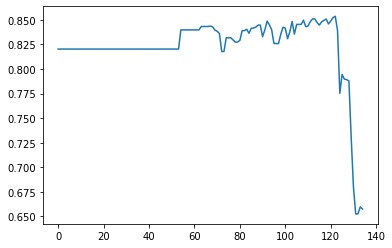

In [211]:
'''
    features selection backpropagation
'''
roc_features_res = []
B = A.copy()
for _ in range(len(A)-2):
    if 'text' in list(B[1][:-1]):
        df2 = df1.loc[:,list(B[1][:-1])]
        omitting = B[1][len(B)-1]
    else:
        df2 = df1.loc[:,list(B[1][:-2])]
        omitting = B[1][len(B)-2]
    df2['id'] = df1['id']
    df2['text'] = df1['text']
    xg_cl, X, y, X_res, X_test, y_test = learn(df2, answers)
    
    predict_proba = xg_cl.predict_proba(X_test)
    roc = sklearn.metrics.roc_auc_score(y_test, pd.DataFrame(predict_proba)[1])
    roc_features_res.append([B[1][len(B)-1], roc])
    print(f'Test roc_auc_score {len(B)} omitting {omitting}: {roc}')
        
    B = pd.DataFrame(zip(xg_cl.feature_importances_, X.columns)).reset_index(drop=True)
    B = B.sort_values(0, ascending=False).reset_index(drop=True)
roc_table = pd.DataFrame(roc_features_res)
roc_table[1].plot()

In [216]:
roc_table = pd.DataFrame(roc_features_res)
print(roc_table[1].argmax())
print(roc_table[1][122])
# pd.DataFrame(roc_features_res)[1].plot()

122
0.8536725987595901


Len of X_train is: 147462
Len of X_test is: 3692
Train F1: 0.15545935545935546
Train roc_auc_score: 0.7945837938883569
Test F1: 0.01
Test roc_auc_score: 0.699135060589723
Test roc_auc_score 1 omitting responsible_count: 0.699135060589723
Len of X_train is: 147462
Len of X_test is: 3692
Train F1: 0.3180139163302122
Train roc_auc_score: 0.8806361505472966
Test F1: 0.23123732251521295
Test roc_auc_score: 0.7584351646385248
Test roc_auc_score 2 omitting views_num: 0.7584351646385248
Len of X_train is: 147462
Len of X_test is: 3692
Train F1: 0.4827695351137487
Train roc_auc_score: 0.9292694724029966
Test F1: 0.21739130434782608
Test roc_auc_score: 0.7607513881529372
Test roc_auc_score 3 omitting text_len: 0.7607513881529372
Len of X_train is: 147462
Len of X_test is: 3692
Train F1: 0.5918254524011352
Train roc_auc_score: 0.94251685137934
Test F1: 0.19238476953907815
Test roc_auc_score: 0.7240824769939537
Test roc_auc_score 4 omitting mineco_solution: 0.7240824769939537
Len of X_train is: 14

Len of X_train is: 147462
Len of X_test is: 3692
Train F1: 0.7598879833862999
Train roc_auc_score: 0.9658006510720283
Test F1: 0.4006908462867012
Test roc_auc_score: 0.851113800388274
Test roc_auc_score 34 omitting developer_ФНС России: 0.851113800388274
Len of X_train is: 147462
Len of X_test is: 3692
Train F1: 0.7575681288942036
Train roc_auc_score: 0.9658392216491862
Test F1: 0.36713286713286714
Test roc_auc_score: 0.8571484766376117
Test roc_auc_score 35 omitting developer_ФТС России: 0.8571484766376117
Len of X_train is: 147462
Len of X_test is: 3692
Train F1: 0.7602416462148386
Train roc_auc_score: 0.9660242936780962
Test F1: 0.35106382978723405
Test roc_auc_score: 0.8578449634286587
Test roc_auc_score 36 omitting act_significance: 0.8578449634286587
Len of X_train is: 147462
Len of X_test is: 3692
Train F1: 0.7631339299733083
Train roc_auc_score: 0.9666061028447247
Test F1: 0.38474870017331025
Test roc_auc_score: 0.8505923994239908
Test roc_auc_score 37 omitting act_changes_cont

Len of X_train is: 147462
Len of X_test is: 3692
Train F1: 0.7578073403151241
Train roc_auc_score: 0.9662693955834223
Test F1: 0.36684303350970016
Test roc_auc_score: 0.8587041951952439
Test roc_auc_score 66 omitting developer_Роскомнадзор: 0.8587041951952439
Len of X_train is: 147462
Len of X_test is: 3692
Train F1: 0.7577651455670362
Train roc_auc_score: 0.9665711143931697
Test F1: 0.4
Test roc_auc_score: 0.8467173721391401
Test roc_auc_score 67 omitting developer_Росфинмониторинг: 0.8467173721391401
Len of X_train is: 147462
Len of X_test is: 3692
Train F1: 0.7618271821542703
Train roc_auc_score: 0.9661421295523439
Test F1: 0.3979057591623036
Test roc_auc_score: 0.8501627835406982
Test roc_auc_score 68 omitting developer_Министерство науки и высшего образования Российской Федерации (Минобрнауки России): 0.8501627835406982
Len of X_train is: 147462
Len of X_test is: 3692
Train F1: 0.75821101926643
Train roc_auc_score: 0.9661890564013746
Test F1: 0.35500878734622143
Test roc_auc_score

Len of X_train is: 147462
Len of X_test is: 3692
Train F1: 0.7593354480072864
Train roc_auc_score: 0.9652346045544097
Test F1: 0.3732876712328767
Test roc_auc_score: 0.8487582404105801
Test roc_auc_score 98 omitting developer_Росздравнадзор: 0.8487582404105801
Len of X_train is: 147462
Len of X_test is: 3692
Train F1: 0.7517600631412786
Train roc_auc_score: 0.9655067256645458
Test F1: 0.3778966131907308
Test roc_auc_score: 0.8509047772206397
Test roc_auc_score 99 omitting developer_Росжелдор: 0.8509047772206397
Len of X_train is: 147462
Len of X_test is: 3692
Train F1: 0.7564708105044399
Train roc_auc_score: 0.9653461957541734
Test F1: 0.4150943396226415
Test roc_auc_score: 0.8512171550172887
Test roc_auc_score 100 omitting developer_Федеральное агентство по делам национальностей: 0.8512171550172887
Len of X_train is: 147462
Len of X_test is: 3692
Train F1: 0.7558366370901769
Train roc_auc_score: 0.965561382561647
Test F1: 0.3801065719360568
Test roc_auc_score: 0.84932129174775
Test ro

Len of X_train is: 147462
Len of X_test is: 3692
Train F1: 0.7557945718149511
Train roc_auc_score: 0.9642628200034994
Test F1: 0.37837837837837834
Test roc_auc_score: 0.8547674636542647
Test roc_auc_score 129 omitting developer_Росфиннадзор: 0.8547674636542647
Len of X_train is: 147462
Len of X_test is: 3692
Train F1: 0.7530805836563612
Train roc_auc_score: 0.963924319588498
Test F1: 0.3674911660777385
Test roc_auc_score: 0.8507867678307945
Test roc_auc_score 130 omitting developer_Рособоронпоставка: 0.8507867678307945
Len of X_train is: 147462
Len of X_test is: 3692
Train F1: 0.7549455750118315
Train roc_auc_score: 0.9647033325895313
Test F1: 0.36524822695035464
Test roc_auc_score: 0.8532371981022857
Test roc_auc_score 131 omitting npa_type_указ: 0.8532371981022857
Len of X_train is: 147462
Len of X_test is: 3692
Train F1: 0.7507101824379774
Train roc_auc_score: 0.9640730022645257
Test F1: 0.3824027072758037
Test roc_auc_score: 0.8510937465050323
Test roc_auc_score 132 omitting year_2

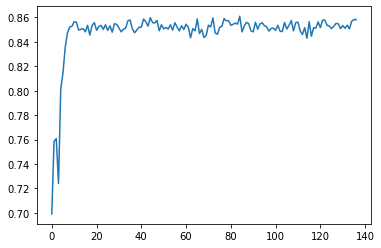

In [70]:
def feature_select_from_list(A, method='xg'):
    roc_features_res = []
    for i in range(1,len(A)):
        df2 = df1.loc[:,list(A[1][:i])]
        df2['id'] = df1['id']
        df2['text'] = df1['text']
        xg_cl, X, y, X_res, X_test, y_test = learn(df2, answers, method)

        predict_proba = xg_cl.predict_proba(X_test)
        roc = sklearn.metrics.roc_auc_score(y_test, pd.DataFrame(predict_proba)[1])
        roc_features_res.append([A[1][i], roc])
        print(f'Test roc_auc_score {i} omitting {A[1][i]}: {roc}')
    #plt.
    roc_table = pd.DataFrame(roc_features_res)
    roc_table[1].plot()
    optimal = roc_table[1].argmax() + 1
    print(f'Optimal number of features from list is: {optimal}')
    df2 = df1.loc[:,list(A[1][:optimal])]
    df2['id'] = df1['id']
    df2['text'] = df1['text']
    print(len(df2.columns))
    xg_cl, X, y, X_res, X_test, y_test = learn(df2, answers, method)
    return roc_table, optimal

roc_table, optimal = feature_select_from_list(A, method='cat')    
    
# roc_features_res = []
# for i in range(1,len(A)):
#     df2 = df1.loc[:,list(A[1][:i])]
#     df2['id'] = df1['id']
#     df2['text'] = df1['text']
#     xg_cl, X, y, X_res, X_test, y_test = learn(df2, answers)
    
#     predict_proba = xg_cl.predict_proba(X_test)
#     roc = sklearn.metrics.roc_auc_score(y_test, pd.DataFrame(predict_proba)[1])
#     roc_features_res.append([A[1][i], roc])
#     print(f'Test roc_auc_score {i} omitting {A[1][i]}: {roc}')
# #plt.
# roc_table = pd.DataFrame(roc_features_res)
# optimal = roc_table[1].argmax() + 1
# df2 = df1.loc[:,list(A[1][:optimal])]
# df2['id'] = df1['id']
# df2['text'] = df1['text']
# print(len(df2.columns))
# xg_cl, X, y, X_res, X_test, y_test = learn(df2, answers)

In [237]:
mandatory_features = {'id', 'text', 'text_len', 'npa_type_nothing', 'npa_type_приказ', 'npa_type_федеральныйзакон', 
                      'npa_type_постановление', 'npa_type_указ'}
mandatory_features = {'id', 'text', 'npa_type_nothing', 'npa_type_федеральныйзакон'}
forbidden_features = {'о','об', 'порядок', 'федеральный', 'приказ', 'проект'}
#63
df2 = df1.loc[:,list(A[1][:60])]
for i in mandatory_features:
    df2[i] = df1[i]
for i in forbidden_features:
    if i in df2.columns:
        del df2[i]
# df2['id'] = df1['id']
# df2['text'] = df1['text']
print(len(df2.columns))
xg_cl, X, y, X_res, X_test, y_test = learn(df2, answers)

63
Len of X_train is: 77314
Len of X_test is: 3692
Train F1: 0.7264900997619893
Train roc_auc_score: 0.9671258539639171
Test F1: 0.48000000000000004
Test roc_auc_score: 0.8930865780130766


62
0.8888606077714969


<AxesSubplot:>

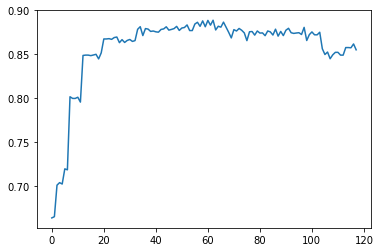

In [181]:
roc_table = pd.DataFrame(roc_features_res)
print(roc_table[1].argmax())
print(roc_table[1][62])
pd.DataFrame(roc_features_res)[1].plot()

<AxesSubplot:>

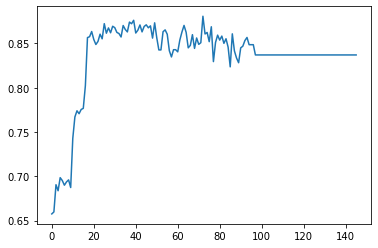

In [168]:
pd.DataFrame(roc_features_res)[1].plot()

In [49]:
Train.columns
dev_mean = Train.groupby('developer').agg({'answer': 'mean'}).sort_values('answer', ascending=False)
D = dict(zip(dev_mean.index, dev_mean['answer']))
dev_mean.index
D

{'Судебный департамент': 0.8292682926829268,
 'Спецстрой России': 0.7659574468085106,
 'Росгвардия': 0.7279411764705882,
 'Пенсионный фонд Российской Федерации': 0.6870229007633588,
 'ГФС России': 0.6736401673640168,
 'Рослесхоз': 0.654320987654321,
 'Федеральная служба по оборонному заказу': 0.631578947368421,
 'Роспечать': 0.6076923076923076,
 'Рособрнадзор': 0.56,
 'ФСС России': 0.558282208588957,
 'ФАНО России ': 0.5555555555555556,
 'Госкорпорация "Роскосмос"': 0.5536912751677853,
 'Росстандарт': 0.5511811023622047,
 'Роснедра': 0.5384615384615384,
 'Минпросвещения России': 0.5298804780876494,
 'Федеральная пробирная палата': 0.4897959183673469,
 'Росграница': 0.4592833876221498,
 'Рособоронпоставка': 0.4444444444444444,
 'Коллегия Военно-промышленной комиссии Российской Федерации': 0.4,
 'Росархив': 0.37967914438502676,
 'Федеральное агентство по делам национальностей': 0.37117903930131,
 'Россельхознадзор': 0.34576271186440677,
 'ГУСП': 0.34523809523809523,
 'Росалкогольрегулиро

In [210]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier()

X = df1[df1['id'].isin(answers['id'])]
id_dict = dict(zip(answers['id'],answers['passed']))
y = np.array([id_dict[i] for i in X['id']])
    
X_test = X[X['text']==1].copy()
X_test = X.loc[sample(list(X_test.index), len(X_test)//2), :].reset_index(drop=True)
y_test = np.array([id_dict[i] for i in X_test['id']])
X_train = X[~X['id'].isin(X_test['id'])].copy().reset_index(drop=True)
y_train = np.array([id_dict[i] for i in X_train['id']])


print(f'Len of X_train is: {len(X_train)} {len(X_train.columns)}')
print(f'Len of X_test is: {len(X_test)} {len(X_test.columns)}')

del X_test['id']
del X_train['id']

del X['id']



knn.fit(X_train, y_train)
# get the most similar neighbor for each point in the test set
neigh_num = 15

neighbor_ix = knn.kneighbors(X_test, neigh_num, return_distance=False)

ix = []
for i in range(neigh_num):
    ix = np.concatenate([ix,neighbor_ix[:,i]]).astype(int)
    
    
ix = np.unique(ix)
# create a training dataset from selected instances
X_train_neigh, y_train_neigh = X_train[X_train.index.isin(ix)], y_train[ix]
print(X_train_neigh.shape, y_train_neigh.shape)



model = KNeighborsClassifier()
# fit model
model.fit(X_train_neigh, y_train_neigh)

# make predictions
yhat = model.predict(X_test)
# evaluate predictions
accuracy = sklearn.metrics.roc_auc_score(y_test, yhat)
print('Accuracy: %.3f' % (accuracy * 100))







X_train, y_train = X_train_neigh, y_train_neigh
eval_set = [(X_test, y_test)]
xg_cl = xgb.XGBClassifier(objective="binary:logistic", n_estimators=1000, seed=111)

xg_cl.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=eval_set, verbose=True)




predict = xg_cl.predict(X_train)
predict_proba = xg_cl.predict_proba(X_train)

print(f'Train F1: {sklearn.metrics.f1_score(y_train, predict)}')
print(f'Train roc_auc_score: {sklearn.metrics.roc_auc_score(y_train, pd.DataFrame(predict_proba)[1])}')





predict = xg_cl.predict(X_test)
predict_proba = xg_cl.predict_proba(X_test)

print(f'Test F1: {sklearn.metrics.f1_score(y_test, predict)}')
print(f'Test roc_auc_score: {sklearn.metrics.roc_auc_score(y_test, pd.DataFrame(predict_proba)[1])}')

Len of X_train is: 77314 140
Len of X_test is: 3692 140
(4163, 139) (4163,)
Accuracy: 50.218
[0]	validation_0-auc:0.72781
[1]	validation_0-auc:0.77428
[2]	validation_0-auc:0.79095
[3]	validation_0-auc:0.80578
[4]	validation_0-auc:0.81695
[5]	validation_0-auc:0.82273


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-auc:0.82613
[7]	validation_0-auc:0.82393
[8]	validation_0-auc:0.82976
[9]	validation_0-auc:0.83075
[10]	validation_0-auc:0.83272
[11]	validation_0-auc:0.83439
[12]	validation_0-auc:0.83302
[13]	validation_0-auc:0.83281
[14]	validation_0-auc:0.83462
[15]	validation_0-auc:0.83655
[16]	validation_0-auc:0.84109
[17]	validation_0-auc:0.83892
[18]	validation_0-auc:0.83970
[19]	validation_0-auc:0.83739
[20]	validation_0-auc:0.83821
[21]	validation_0-auc:0.84110
[22]	validation_0-auc:0.84135
[23]	validation_0-auc:0.84173
[24]	validation_0-auc:0.84176
[25]	validation_0-auc:0.84134
[26]	validation_0-auc:0.84105
[27]	validation_0-auc:0.84071
[28]	validation_0-auc:0.84307
[29]	validation_0-auc:0.84332
[30]	validation_0-auc:0.84266
[31]	validation_0-auc:0.84317
[32]	validation_0-auc:0.84432
[33]	validation_0-auc:0.84505
[34]	validation_0-auc:0.84413
[35]	validation_0-auc:0.84373
[36]	validation_0-auc:0.84472
[37]	validation_0-auc:0.84598
[38]	validation_0-auc:0.84599
[39]	validatio

<AxesSubplot:>

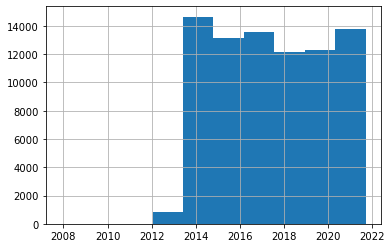

In [123]:
%matplotlib inline
Train['publication_date'] = [np.nan if x=='nothing' else x for x in Train['publication_date']]
Train = Train.dropna()
#Train['publication_date'].value_counts().plot.hist()
Train['publication_date'].hist()

<AxesSubplot:>

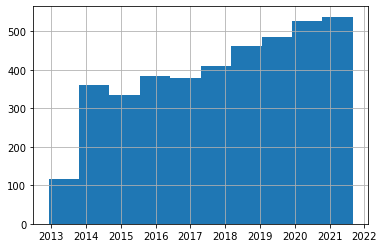

In [34]:
Test['publication_date'].hist()

In [127]:
Train['year'] = [0 if x=='nothing' else str(x.year) + "-" + str(x.month) for x in Train['publication_date']]
GT = Train.groupby('year').mean()
display(GT.iloc[-21:])
#Train['year'] = [x.year for x in Train['publication_date']]
Train['month'] = [np.nan if x.year in [2007, 2012, 2013, 2020, 2021] else x.month for x in Train['publication_date']]
Train = Train.dropna()
Train.groupby('month').mean()

,answer,month
year,,
2019-12,0.118182,12.0
2019-2,0.165975,2.0
2019-3,0.194743,3.0
2019-4,0.171642,4.0
2019-5,0.177814,5.0
2019-6,0.139410,6.0
2019-7,0.123835,7.0
2019-8,0.126374,8.0
2019-9,0.107673,9.0


,answer
month,
1.0,0.145809
2.0,0.159797
3.0,0.150168
4.0,0.149245
5.0,0.129587
6.0,0.156849
7.0,0.157378
8.0,0.142542
9.0,0.145197


,answer
year,
2020-1,0.162047
2020-10,0.108080
2020-11,0.083420
2020-12,0.097938
2020-2,0.166913
2020-3,0.151079
2020-4,0.154506
2020-5,0.124615
2020-6,0.138325


0        2013
1        2013
2        2013
3        2013
4        2014
         ... 
85001    2021
85002    2021
85003    2021
85004    2021
85005    2021
Name: month, Length: 85006, dtype: int64

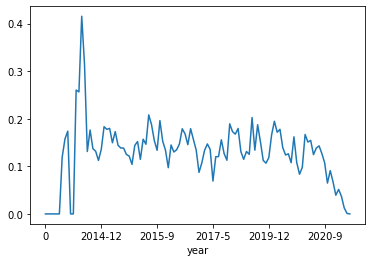

In [100]:
display(GT.iloc[-21:])
GT['answer'].plot()
df1['month']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


array([[<AxesSubplot:title={'center':'developer_Росгвардия'}>,
        <AxesSubplot:title={'center':'developer_Рослесхоз'}>,
        <AxesSubplot:title={'center':'developer_Минздрав России'}>,
        <AxesSubplot:title={'center':'developer_Минстрой России'}>,
        <AxesSubplot:title={'center':'developer_Минюст России'}>,
        <AxesSubplot:title={'center':'developer_ГФС России'}>,
        <AxesSubplot:title={'center':'developer_Роспечать'}>,
        <AxesSubplot:title={'center':'developer_Госкорпорация "Роскосмос"'}>],
       [<AxesSubplot:title={'center':'developer_Росграница'}>,
        <AxesSubplot:title={'center':'developer_Рособрнадзор'}>,
        <AxesSubplot:title={'center':'developer_Минпросвещения России'}>,
        <AxesSubplot:title={'center':'developer_Госкорпорация "Росатом"'}>,
        <AxesSubplot:title={'center':'developer_ФСС России'}>,
        <AxesSubplot:title={'center':'developer_Спецстрой России'}>,
        <AxesSubplot:title={'center':'developer_Пенсионный 

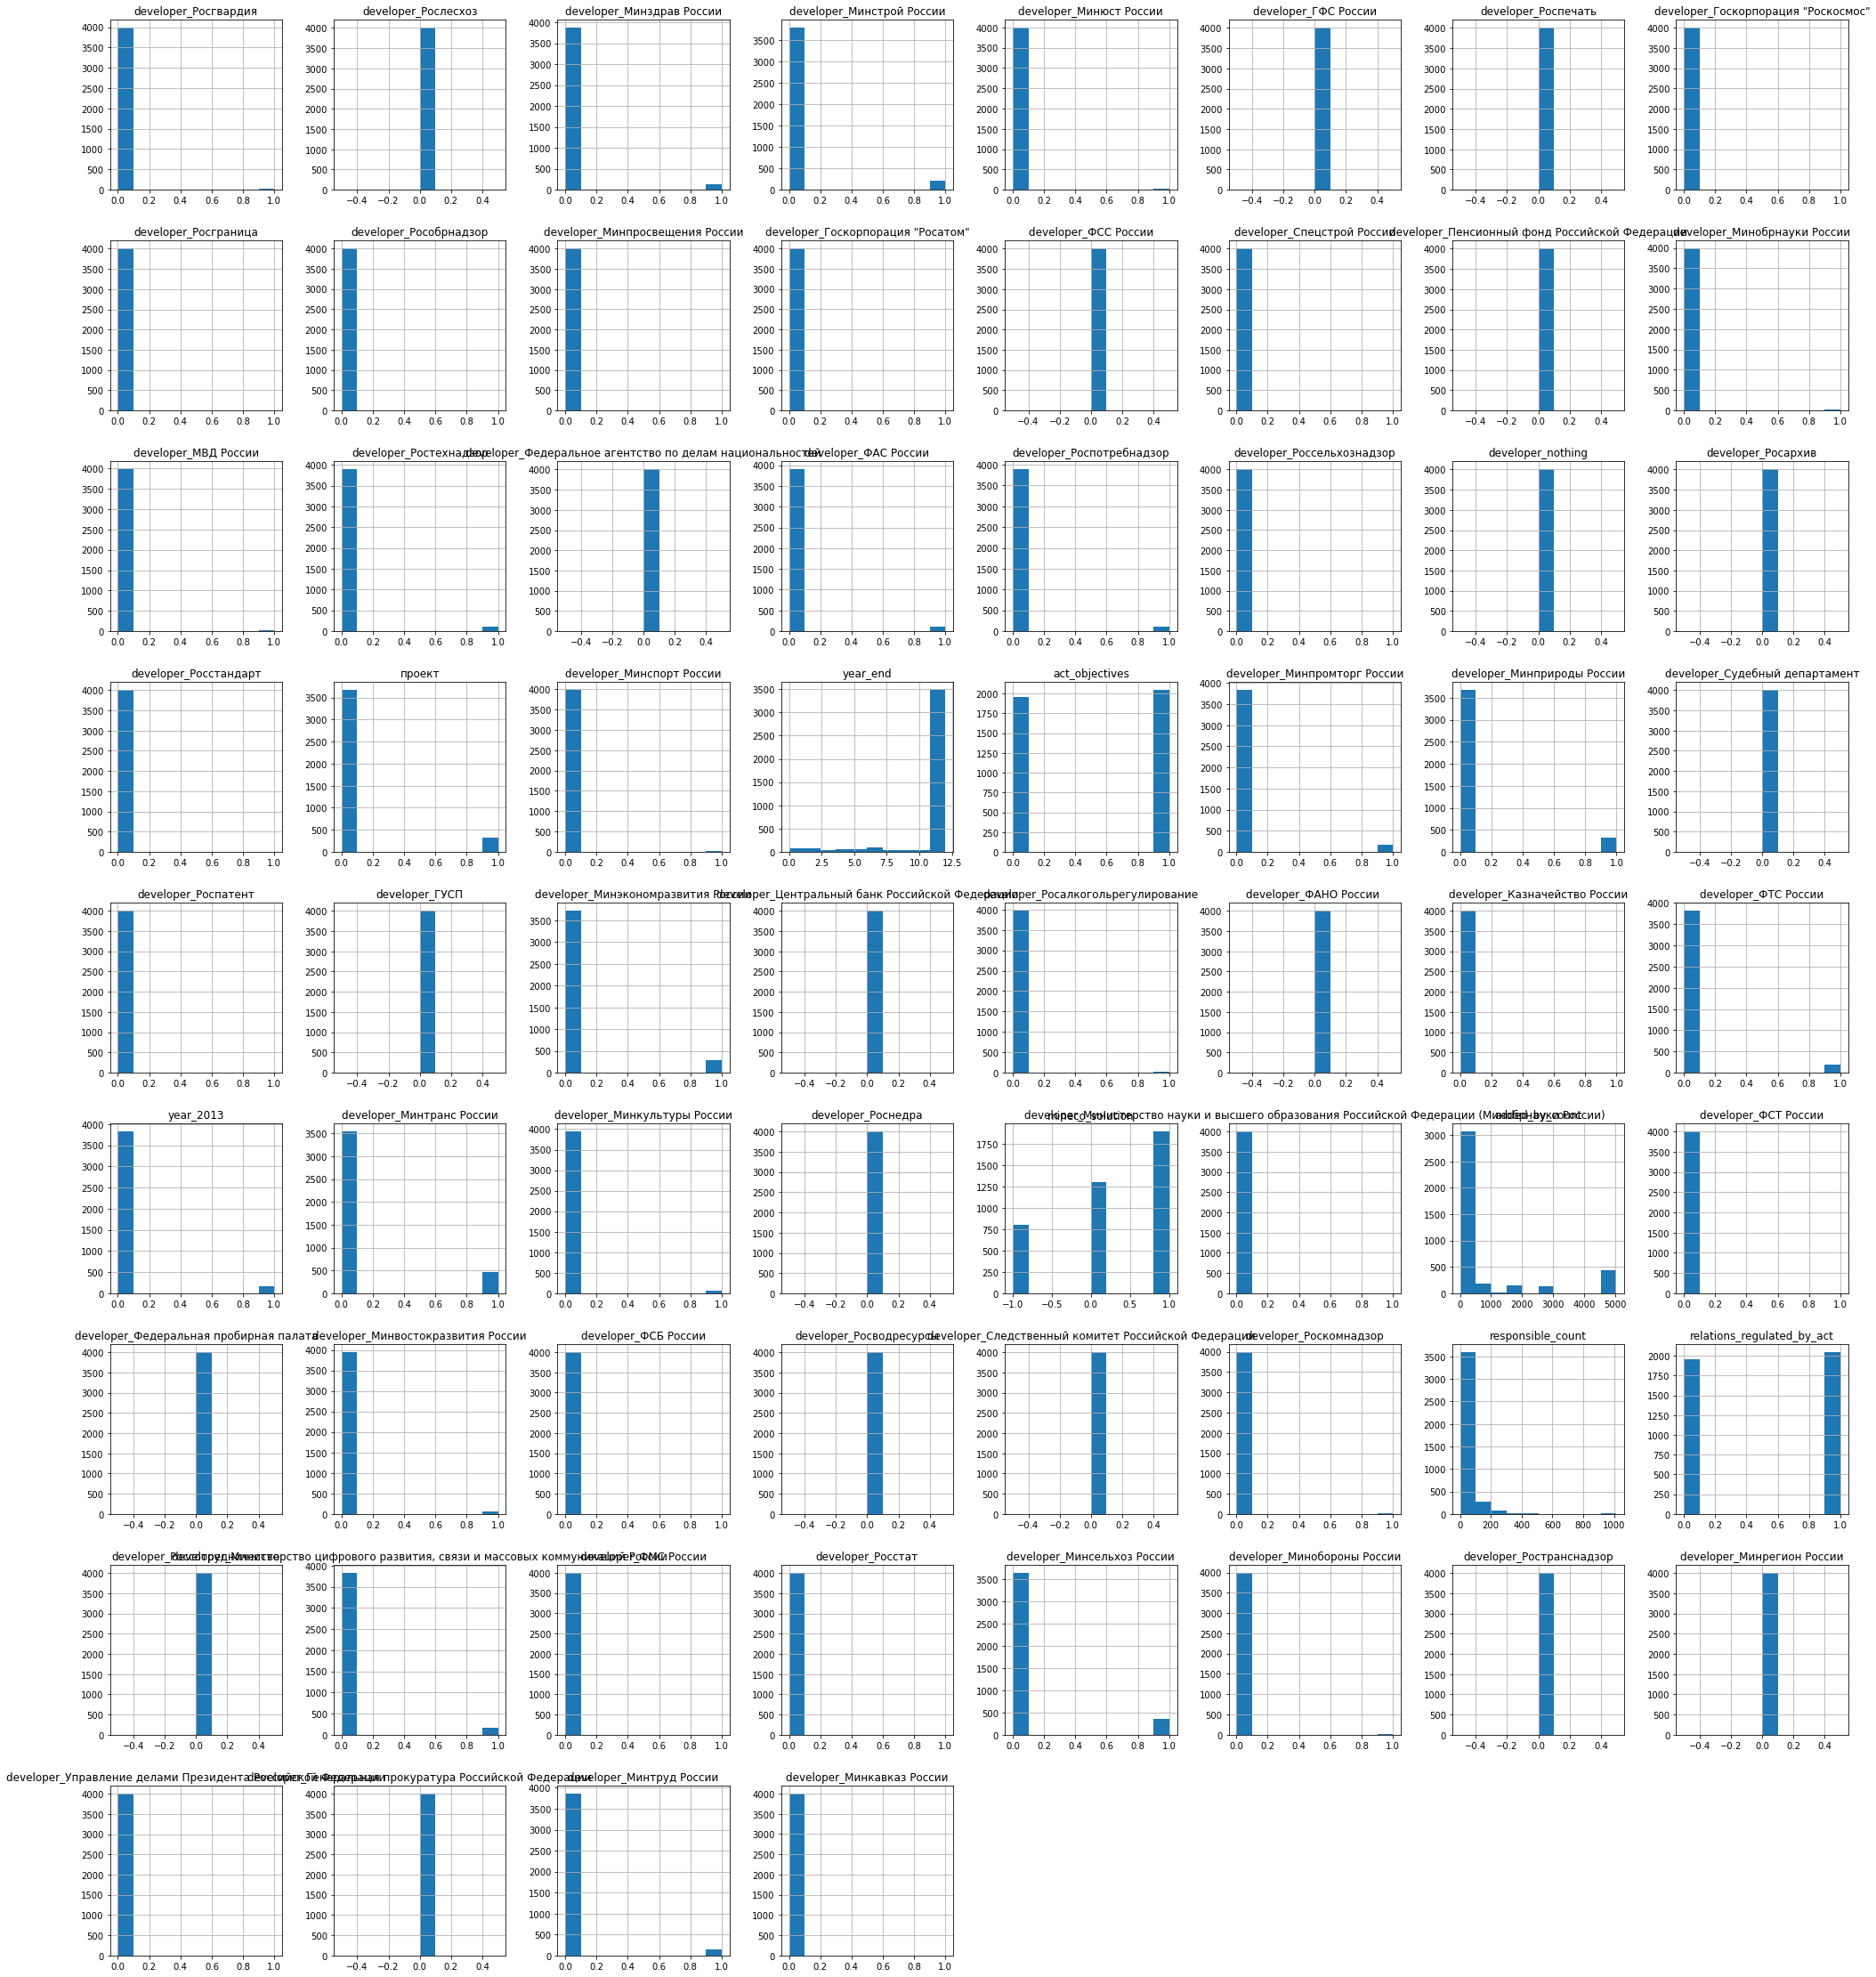

In [137]:
fig = plt.figure(figsize = (35,40))
ax = fig.gca()

X_res.hist(ax = ax)